<a href="https://colab.research.google.com/github/adl09/GPU_IB/blob/main/Clase1/ICNPG_AddTwoVectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Suma de dos vectores: CUDA-C vs C

Nuevamente vamos a analizar el caso simple, vergonzosamente paralelo, de sumar dos vectores grandes.

In [1]:
%%writefile add.cu
#include <iostream>
#include <cstdlib>
#include <ctime>
#include <cuda_runtime.h>

#define N (1 << 24)  // Vector size: 16 million elements

// GPU Kernel for vector addition
__global__ void vectorAddGPU(float* a, float* b, float* c, int n) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n) {
        c[idx] = a[idx] + b[idx];
    }
}

// CPU function for vector addition
void vectorAddCPU(float* a, float* b, float* c, int n) {
    for (int i = 0; i < n; i++) {
        c[i] = a[i] + b[i];
    }
}

int main() {
    float *h_a, *h_b, *h_c, *d_a, *d_b, *d_c;
    size_t size = N * sizeof(float);

    // Allocate memory on host
    h_a = (float*)malloc(size);
    h_b = (float*)malloc(size);
    h_c = (float*)malloc(size);

    // Initialize vectors with random values
    srand(time(0));
    for (int i = 0; i < N; i++) {
        h_a[i] = static_cast<float>(rand()) / RAND_MAX;
        h_b[i] = static_cast<float>(rand()) / RAND_MAX;
        h_c[i] = 0.0f;
    }

    // -------------------- CPU Computation --------------------
    clock_t start_cpu = clock();
    vectorAddCPU(h_a, h_b, h_c, N);
    clock_t end_cpu = clock();
    double cpu_time = double(end_cpu - start_cpu) / CLOCKS_PER_SEC;
    std::cout << "CPU Time: " << cpu_time << " sec" << std::endl;

    // -------------------- GPU Computation --------------------
    cudaMalloc((void**)&d_a, size);
    cudaMalloc((void**)&d_b, size);
    cudaMalloc((void**)&d_c, size);

    cudaMemcpy(d_a, h_a, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_b, h_b, size, cudaMemcpyHostToDevice);

    // Define execution configuration
    int threadsPerBlock = 256;
    int blocksPerGrid = (N + threadsPerBlock - 1) / threadsPerBlock;

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);
    vectorAddGPU<<<blocksPerGrid, threadsPerBlock>>>(d_a, d_b, d_c, N);
    cudaEventRecord(stop);
    cudaError_t err = cudaGetLastError();
    if (err != cudaSuccess) {
      std::cerr << "CUDA Kernel Error: " << cudaGetErrorString(err) << std::endl;
    }

    cudaMemcpy(h_c, d_c, size, cudaMemcpyDeviceToHost);

    cudaEventSynchronize(stop);

    float gpu_time;
    cudaEventElapsedTime(&gpu_time, start, stop);
    std::cout << "GPU Time: " << gpu_time / 1000.0 << " sec" << std::endl;

    std::cout << "Speedup: " << cpu_time/(gpu_time / 1000.0) << "x" << std::endl;

    // Compare results (basic check)
    bool correct = true;
    for (int i = 0; i < 10; i++) {
        std::cout << "h_a[" << i << "] = " << h_a[i] << ", h_b[" << i << "] = " << h_b[i] << ", h_c[" << i << "] = " << h_c[i] << std::endl;
        if (fabs(h_c[i] - (h_a[i] + h_b[i])) > 1e-3) {
            correct = false;
            break;
        }
    }
    std::cout << (correct ? "Results match!" : "Results mismatch!") << std::endl;

    // Free memory
    free(h_a); free(h_b); free(h_c);
    cudaFree(d_a); cudaFree(d_b); cudaFree(d_c);

    return 0;
}


Writing add.cu


In [2]:
!nvcc -arch=sm_75 add.cu -o add  # Replace with actual compute capability

correr mas de una vez el ejecutable, ya que los tiempos pueden fluctuar...

In [3]:
!./add

CPU Time: 0.063804 sec
GPU Time: 0.000890304 sec
Speedup: 71.6654x
h_a[0] = 0.505647, h_b[0] = 0.401567, h_c[0] = 0.907213
h_a[1] = 0.881412, h_b[1] = 0.277624, h_c[1] = 1.15904
h_a[2] = 0.517565, h_b[2] = 0.606618, h_c[2] = 1.12418
h_a[3] = 0.819824, h_b[3] = 0.912851, h_c[3] = 1.73268
h_a[4] = 0.709203, h_b[4] = 0.672564, h_c[4] = 1.38177
h_a[5] = 0.293962, h_b[5] = 0.129786, h_c[5] = 0.423748
h_a[6] = 0.888326, h_b[6] = 0.357277, h_c[6] = 1.2456
h_a[7] = 0.422798, h_b[7] = 0.298416, h_c[7] = 0.721214
h_a[8] = 0.346028, h_b[8] = 0.346742, h_c[8] = 0.69277
h_a[9] = 0.646714, h_b[9] = 0.195051, h_c[9] = 0.841765
Results match!


# Tarea

1. Modificar el programa anterior para que acepte $N$ como input, calcule el tiempo de la suma en GPU y CPU, t_suma_GPU y t_suma_CPU respectivamente, y el tiempo de la suma mas la copia H2D y D2H en GPU, t_total_GPU.

2. Generar un archivo de dos columnas:


  | N | t_suma_CPU | t_suma_GPU | t_total_GPU |
  |----------|----------|----------|----------|
  | 1000   | Data 2   | Data 3   | Data 4   |
  | 10000   | Data 2   | Data 3   | Data 4   |
  | 100000   | Data 2   | Data 3   | Data 4   |
  | 1000000   | Data 2   | Data 3   | Data 4   |
  | 10000000   | Data 2   | Data 3   | Data 4   |
  | ...   | Data 2   | Data 3   | Data 4   |
  | ¿cual es el limite?   | Data 2   | Data 4   | Data 3   |

  donde

  * t_suma es el tiempo solo de la suma
  * t_total es el tiempo de la suma mas el tiempo de las copias H2D y D2H.

2. Graficar todos los tiempos vs $N$, analizar como escalean, y discutir.

3. Modificar el código para que calcule $x[i]=a*x[i]+y[i]$, donde $a$ es una constante. Este algoritmo se llama SAXPY (la S es de single precision, otras variantes para precision doble o enteros son DAXPY o AXPY).

4. Cambiar la configuración de la grilla: ¿$N$ bloques de un hilo? ¿Un bloque con $N$ hilos?

5. ¿Qué sucede si eliminamos los CudaDeviceSynchronize()?

In [88]:
%%writefile tarea1.cu
#include <iostream>
#include <cstdlib>
#include <ctime>
#include <cuda_runtime.h>

// GPU Kernel for vector addition
__global__ void vectorAddGPU(float* a, float* b, float* c, int n) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n) {
        c[idx] = a[idx] + b[idx];
    }
}

// CPU function for vector addition
void vectorAddCPU(float* a, float* b, float* c, int n) {
    for (int i = 0; i < n; i++) {
        c[i] = a[i] + b[i];
    }
}

int main(int argN, char** argv) {
    int N;
    if (argN > 1){
      N = atoi(argv[1]);
    } else {
      N = 1 << 24;
    }

    float *h_a, *h_b, *h_c, *d_a, *d_b, *d_c;
    size_t size = N * sizeof(float);

    // Allocate memory on host
    h_a = (float*)malloc(size);
    h_b = (float*)malloc(size);
    h_c = (float*)malloc(size);

    // Initialize vectors with random values
    srand(time(0));
    for (int i = 0; i < N; i++) {
        h_a[i] = static_cast<float>(rand()) / RAND_MAX;
        h_b[i] = static_cast<float>(rand()) / RAND_MAX;
        h_c[i] = 0.0f;
    }

    // -------------------- CPU Computation --------------------
    clock_t start_cpu = clock();
    vectorAddCPU(h_a, h_b, h_c, N);
    clock_t end_cpu = clock();
    double cpu_time = double(end_cpu - start_cpu) / CLOCKS_PER_SEC;
    //std::cout << "CPU Time: " << cpu_time << " sec" << std::endl;

    // -------------------- GPU Computation --------------------
    cudaMalloc((void**)&d_a, size);
    cudaMalloc((void**)&d_b, size);
    cudaMalloc((void**)&d_c, size);

    float gpu_total_time;
    cudaEvent_t start_withcpy, stop_withcpy;
    cudaEventCreate(&start_withcpy);
    cudaEventCreate(&stop_withcpy);

    cudaEventRecord(start_withcpy);

    cudaMemcpy(d_a, h_a, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_b, h_b, size, cudaMemcpyHostToDevice);

    // Define execution configuration
    int threadsPerBlock = 256;
    int blocksPerGrid = (N + threadsPerBlock - 1) / threadsPerBlock;

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);
    vectorAddGPU<<<blocksPerGrid, threadsPerBlock>>>(d_a, d_b, d_c, N);
    cudaEventRecord(stop);
    cudaError_t err = cudaGetLastError();
    if (err != cudaSuccess) {
      std::cerr << "CUDA Kernel Error: " << cudaGetErrorString(err) << std::endl;
    }

    cudaMemcpy(h_c, d_c, size, cudaMemcpyDeviceToHost);
    cudaEventRecord(stop_withcpy);

    cudaEventSynchronize(stop);
    cudaEventSynchronize(stop_withcpy);

    float gpu_time;
    cudaEventElapsedTime(&gpu_time, start, stop);
    cudaEventElapsedTime(&gpu_total_time, start_withcpy, stop_withcpy);
    //std::cout << "GPU Time: " << gpu_time / 1000.0 << " sec" << std::endl;
    //std::cout << "GPU Time: " << gpu_time / 1000.0 << " sec" << std::endl;

    //std::cout << "Speedup: " << cpu_time/(gpu_time / 1000.0) << "x" << std::endl;

    // Imprimo resultados en una linea
    std::cout << N << " " << cpu_time << " " << gpu_time / 1000.0 << " " << gpu_total_time/1000.0 << " "<< (gpu_time / 1000.0) / (cpu_time) << std::endl;

    // Free memory
    free(h_a); free(h_b); free(h_c);
    cudaFree(d_a); cudaFree(d_b); cudaFree(d_c);

    return 0;
}


Overwriting tarea1.cu


In [89]:
!nvcc -arch=sm_75 tarea1.cu -o tarea1  # Replace with actual compute capability

In [95]:
%%bash
rm tarea1.dat
echo "N CPU GPU Speedup"
FIRST=3
LAST=8
INCREMENT=1

for i in $(seq $FIRST $INCREMENT $LAST); do
  N=$((10**$i));  # Correct way to calculate 10^i
  # print i in console
  ./tarea1 $N >> tarea1.dat
done

N CPU GPU Speedup
3
4
5
6
7
8


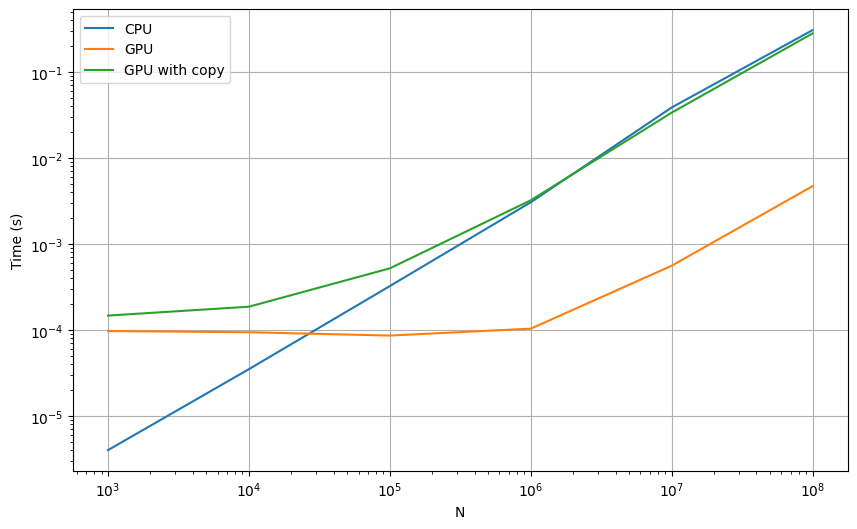

In [96]:
# Plot de tarea1.dat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

data = pd.read_csv('tarea1.dat', sep=' ', header=None, names=['N', 'CPU', 'GPU', 'GPU_withcpy','Speedup'])

# plot N vs CPU and GPU
plt.figure(figsize=(10, 6))
plt.loglog(data['N'], data['CPU'], label='CPU')
plt.loglog(data['N'], data['GPU'], label='GPU')
plt.loglog(data['N'], data['GPU_withcpy'], label='GPU with copy')
plt.legend()
plt.xlabel('N')
plt.ylabel('Time (s)')
plt.grid(True)
plt.show()




# Profiling

Un profiling básico del código CUDA se obtiene usando el comando "nvprof"

In [ ]:
!nvprof ./add

CPU Time: 0.054392 sec
==6069== NVPROF is profiling process 6069, command: ./add
GPU Time: 0.000873312 sec
Speedup: 62.2824x
h_a[0] = 0.373852, h_b[0] = 0.823837, h_c[0] = 1.19769
h_a[1] = 0.188026, h_b[1] = 0.537949, h_c[1] = 0.725975
h_a[2] = 0.140692, h_b[2] = 0.47351, h_c[2] = 0.614202
h_a[3] = 0.743308, h_b[3] = 0.782842, h_c[3] = 1.52615
h_a[4] = 0.670559, h_b[4] = 0.634817, h_c[4] = 1.30538
h_a[5] = 0.135769, h_b[5] = 0.466437, h_c[5] = 0.602206
h_a[6] = 0.417194, h_b[6] = 0.757118, h_c[6] = 1.17431
h_a[7] = 0.128106, h_b[7] = 0.500637, h_c[7] = 0.628742
h_a[8] = 0.790354, h_b[8] = 0.921458, h_c[8] = 1.71181
h_a[9] = 0.406634, h_b[9] = 0.921733, h_c[9] = 1.32837
Results match!
==6069== Profiling application: ./add
==6069== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   64.52%  28.247ms         2  14.123ms  14.106ms  14.141ms  [CUDA memcpy HtoD]
                   33.72%  14.762ms         1  14.762ms  14.762m

## gprof para CPU
Uno equivalente para CPU es el gprof

In [ ]:
%%writefile sumacpu.cpp

#include <iostream>
#include <cstdlib>
#include <ctime>
#include <fstream>


// CPU function for vector addition
void vectorAddCPU(float* a, float* b, float* c, int n) {
    for (int i = 0; i < n; i++) {
        c[i] = a[i] + b[i];
    }
}

int main() {

    int N=16777216;
    float *h_a, *h_b, *h_c;
    size_t size = N * sizeof(float);

    // Allocate memory on host
    h_a = (float*)malloc(size);
    h_b = (float*)malloc(size);
    h_c = (float*)malloc(size);

    // Initialize vectors with random values
    srand(time(0));
    for (int i = 0; i < N; i++) {
        h_a[i] = static_cast<float>(rand()) / RAND_MAX;
        h_b[i] = static_cast<float>(rand()) / RAND_MAX;
        h_c[i] = 0.0f;
    }

    // -------------------- CPU Computation --------------------
    clock_t start_cpu = clock();
    vectorAddCPU(h_a, h_b, h_c, N);
    clock_t end_cpu = clock();
    double cpu_time = double(end_cpu - start_cpu) / CLOCKS_PER_SEC;
    std::cout << "CPU Time: " << cpu_time << " sec" << std::endl;

    return 0;
}

Overwriting sumacpu.cpp


In [ ]:
!g++ -pg sumacpu.cpp -o sumacpu; ./sumacpu; echo "############"; gprof ./sumacpu

CPU Time: 0.057967 sec
############
Flat profile:

Each sample counts as 0.01 seconds.
  %   cumulative   self              self     total           
 time   seconds   seconds    calls  ms/call  ms/call  name    
 73.08      0.19     0.19                             main
 19.23      0.24     0.05        1    50.00    50.00  vectorAddCPU(float*, float*, float*, int)
  7.69      0.26     0.02                             _init
  0.00      0.26     0.00        1     0.00     0.00  __static_initialization_and_destruction_0(int, int)

 %         the percentage of the total running time of the
time       program used by this function.

cumulative a running sum of the number of seconds accounted
 seconds   for by this function and those listed above it.

 self      the number of seconds accounted for by this
seconds    function alone.  This is the major sort for this
           listing.

calls      the number of times this function was invoked, if
           this function is profiled, else bla

# Suma de vectores en CUDA pyhton, usando cupy

ya veremos en mas detalle CUDA python, pero este ejemplo ya da una idea, usando cupy en esta oportunidad.

Una forma es usar CUDA C para el kernel, y cupy y numpy vectors para el manejor de la memoria.

In [ ]:
import cupy as cp

ker = cp.RawKernel(r'''
extern "C" __global__
void vector_add(const float *a, const float *b, float *c, int N) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < N) {
        c[idx] = a[idx] + b[idx];
    }
}
''', 'vector_add')

N = 16777216
a = cp.random.rand(N, dtype=cp.float32)
b = cp.random.rand(N, dtype=cp.float32)
c = cp.empty_like(a)

threads_per_block = 256
blocks_per_grid = (N + threads_per_block - 1) // threads_per_block

cp.cuda.Device(0).synchronize()
start = cp.cuda.Event()
end = cp.cuda.Event()

start.record()
ker((blocks_per_grid,), (threads_per_block,), (a, b, c, N))
end.record()
end.synchronize()

print(f"CuPy RawKernel Execution Time: {cp.cuda.get_elapsed_time(start, end) / 1000:.6f} seconds")


CuPy RawKernel Execution Time: 0.036682 seconds


Como el kernel es muy simple, hay formas de evitar su escritura usando funciones u operadores de cupy.

In [ ]:
import numpy as np
import cupy as cp
import time

# Vector size
N = 1 << 24

# Create random vectors
a_cpu = np.random.rand(N).astype(np.float32)
b_cpu = np.random.rand(N).astype(np.float32)
c_cpu = np.empty_like(a_cpu)

# ----- CPU Computation -----
start_cpu = time.time()
c_cpu[:] = a_cpu + b_cpu
end_cpu = time.time()
cpu_time = end_cpu - start_cpu

start_gpu_tot = time.time()

# Move data to GPU
a_gpu = cp.array(a_cpu)  # Copy from NumPy to CuPy
b_gpu = cp.array(b_cpu)
c_gpu = cp.empty_like(a_gpu) # Allocate
c_gpu_np = np.empty_like(c_cpu)
c_gpu_np = c_gpu_np.reshape(c_gpu.shape)

# ----- GPU Computation -----

start = cp.cuda.Event()
end = cp.cuda.Event()

#start_gpu = time.time()
start.record()
c_gpu[:] = a_gpu + b_gpu
end.record()
#cp.cuda.Device(0).synchronize()  # Ensure GPU computation is finished
#end_gpu = time.time()
#gpu_time = end_gpu - start_gpu

# Validate results
c_gpu_np[:] = c_gpu.get()  # Convert back to NumPy

end_gpu_tot = time.time()

gpu_time_tot = end_gpu_tot - start_gpu_tot
gpu_time = cp.cuda.get_elapsed_time(start, end) / 1000


# Print results
print(f"N: {N}")
print(f"CPU Time: {cpu_time:.6f} seconds")
print(f"GPU Time: {gpu_time:.6f} seconds")
print(f"Speedup: {cpu_time / gpu_time:.2f}x")
print(f"GPU Time sima + copia2: {gpu_time_tot:.6f} seconds")

assert np.allclose(c_cpu, c_gpu_np), "Results do not match!"


N: 16777216
CPU Time: 0.056436 seconds
GPU Time: 0.001316 seconds
Speedup: 42.87x
GPU Time sima + copia2: 0.101210 seconds


# Apéndice

A veces, cuando uno copia codigo, aparece un error que se soluciona corriendo esto

In [ ]:
import locale

def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

locale.getpreferredencoding = getpreferredencoding

Para ver la placa y el compilador a disposición.

In [ ]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
Mon Feb  3 18:54:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   73C    P0       

# Solución

Escribir soluciones aquí abajo.